# Project work - Air pollution and covid-19

## Which effect did the restrictions have on no2 levels across scandinavia and to what extend could they help live up to guidelines from WHO.

### Introduction
Link: https://www.greenfacts.org/en/nitrogen-dioxide-no2/

Link: https://dce.au.dk/aktuelt/nyheder/nyhed/artikel/nyt-beregningsgrundlag-viser-hoejere-pris-for-luftforurening/ 

Cities around the world are all affected by air pollution from vehicles and other pollutants. Most of these are closely linked to the same pollutants and it can therefore be hard to seperate their effect. It is known though that air pollution is a large problem, even in countries that define themself as green and developed countries. Studies from Denmark showed that air pollitions cause more than 4000 persons to die too early and a societal cost of more than 75 billions yearly. These are quite large numbers for a small country as Denmark and suggest that considerable savings can be made by decreasing air pollution.


Link: https://www.who.int/news-room/feature-stories/detail/what-are-the-who-air-quality-guidelines

As much of the air pollution comes from transportation in cities, it is assumed that the corona lockdowns would decrease the air pollution considerably. Therefore the effect on air pollution of the different lockdown meassures will be compared with pre-covid levels for multiple large citites across Scandinavian. As a meassure of the effect of the lockdowns the air pollutant NO2, which is assosiated with decreased lung capacity and in some studies, increased mortality, will be accessed. These NO2 levels will then be compared to the guidelines for pollution set by WHO.


### Insert Reader Guidance for website.

### Data collection.

To analyse the effect of corona lockdowns on air pollution in cities across Scandinavia two main data sources are used.


#### NO2 Data
The first source is data on NO2 levels collected from the European Environment Information and Observation Network, which is a partnership network of the European Enviornmental Agency (EEA). Each dataset consist of hourly observation across a year from a measurement station. This is then collected for 2019 and 2020, for 2 cities across Finland, Denmark, Norway and Sweden. 

Link: https://www.eionet.europa.eu/

Link: https://discomap.eea.europa.eu/map/fme/AirQualityExport.htm

#### Restrictions measures.
The second source is the European Centre for Disease Prevention and Control, where a dataset of the restrictions enforced by each country and the period in effect is collected. This is used to see which social restrictions was enforced at any given time and then compare to the NO2 levels. 

Link: https://www.ecdc.europa.eu/en/publications-data/download-data-response-measures-covid-19

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bokeh.models import ColumnDataSource, Legend, HoverTool
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import layout
from bokeh.models.widgets import Tabs, Panel
from bokeh.io import curdoc, output_notebook
import seaborn as sns
import geopandas as gpd
import folium
from folium.plugins import TimeSliderChoropleth
import json
import branca.colormap as cm
import datetime
from folium import plugins
from folium.plugins import HeatMap

# LOAD DATA FOR NO2

In [2]:
### Import data sets v2
## Import data sets from Denmark
columns = ["Concentration", "SamplingPoint","DatetimeBegin", "DatetimeEnd"]

# København
dk2019 = pd.read_csv("data2/DK_8_9294_2019_timeseries.csv", sep=',',usecols=columns) 
dk2020 = pd.read_csv("data2/DK_8_9294_2020_timeseries.csv", sep=',',usecols=columns)
# Århus
dk2019_2 = pd.read_csv("data2/DK_8_9179_2019_timeseries.csv", sep=',',usecols=columns)
dk2020_2 = pd.read_csv("data2/DK_8_9179_2020_timeseries.csv", sep=',',usecols=columns)

## Import data sets from Finland
# Helsinki
fi2019 = pd.read_csv("data2/FI_8_15510_2019_timeseries.csv", sep=',',usecols=columns)
fi2020 = pd.read_csv("data2/FI_8_15510_2020_timeseries.csv", sep=',',usecols=columns)
# Oulu
fi2019_2 = pd.read_csv("data2/FI_8_15639_2019_timeseries.csv", sep=',',usecols=columns)
fi2020_2 = pd.read_csv("data2/FI_8_15639_2020_timeseries.csv", sep=',',usecols=columns)

## Import data sets from Norway
# Oslo
no2019 = pd.read_csv("data2/NO_8_28784_2019_timeseries.csv", sep=',',usecols=columns)
no2020 = pd.read_csv("data2/NO_8_28784_2020_timeseries.csv", sep=',',usecols=columns)

# Trondheim
no2019_2 = pd.read_csv("data2/NO_8_48878_2019_timeseries.csv", sep=',',usecols=columns)
no2020_2 = pd.read_csv("data2/NO_8_48878_2020_timeseries.csv", sep=',',usecols=columns)

## Import data sets from Sweden
# Stockholm
se2019 = pd.read_csv("data2/SE_8_30921_2019_timeseries.csv", sep=',',usecols=columns)
se2020 = pd.read_csv("data2/SE_8_30921_2020_timeseries.csv", sep=',',usecols=columns)
# Umeå
se2019_2 = pd.read_csv("data2/SE_8_30905_2019_timeseries.csv", sep=',',usecols=columns)
se2020_2 = pd.read_csv("data2/SE_8_30905_2020_timeseries.csv", sep=',',usecols=columns)

# Load metadata from datasets
metadata_columns = ["Countrycode", "SamplingPoint", "AirQualityStationType", "AirQualityStationArea", 'Longitude', 'Latitude']
metadata = pd.read_csv("data2/PanEuropean_metadata.csv", sep='\t', usecols=metadata_columns)

# Initial work on data
data = [dk2019, dk2019_2, dk2020, dk2020_2, fi2019, fi2019_2, fi2020, fi2020_2, no2019, no2019_2, no2020, no2020_2, se2019, se2019_2, se2020, se2020_2]
met = {} # dict for metadata

# dicts for daily, weekly and monthly means
daily_means = {}
weekly_means = {}
monthly_means = {}

for i in range(len(data)): # For each data set
    ## Add relevant columns
    data[i]["DatetimeBegin"] = pd.to_datetime(data[i]["DatetimeBegin"], format="%Y-%m-%d %H:%M") # Convert date to datetime
    data[i]["Date"] = pd.DatetimeIndex(data[i]["DatetimeBegin"]).date # Store date in seperate column
    data[i]["Week"] = pd.array(pd.DatetimeIndex(data[i]["DatetimeBegin"]).isocalendar().week) # Store week in seperate column
    data[i]["Month"] = pd.DatetimeIndex(data[i]["DatetimeBegin"]).month # Store month in seperate column
    data[i]["Year"] = pd.DatetimeIndex(data[i]["DatetimeBegin"]).year # Store month in seperate column
    data[i]=data[i].drop(columns=["DatetimeBegin", "DatetimeEnd"])
    ## Determine longitude and latitude to for each measuring station
    met[i] = metadata[metadata["SamplingPoint"] == data[i]["SamplingPoint"].unique()[0]]
    
    ## Add longitude and latitude for each measuring station
    data[i]["lon"] = met[i]["Longitude"].iloc[0]
    data[i]["lat"] = met[i]["Latitude"].iloc[0]
    
    ## Find means
    daily_means[i] = data[i][["Concentration", "Date"]].groupby(["Date"]).mean().reset_index()
    weekly_means[i] = data[i][["Concentration", "Week"]].groupby(["Week"]).mean().reset_index()
    monthly_means[i] = data[i][["Concentration", "Month"]].groupby(["Month"]).mean().reset_index()
    
    

In [3]:
data[1]

,SamplingPoint,Concentration,Date,Week,Month,Year,lon,lat
0,SPO-DK0051A_00008_100,2.721,2019-01-01,1,1,2019,10.200842,56.150558
1,SPO-DK0051A_00008_100,NaN,2019-01-01,1,1,2019,10.200842,56.150558
2,SPO-DK0051A_00008_100,1.611,2019-01-01,1,1,2019,10.200842,56.150558
3,SPO-DK0051A_00008_100,0.529,2019-01-01,1,1,2019,10.200842,56.150558
4,SPO-DK0051A_00008_100,1.108,2019-01-01,1,1,2019,10.200842,56.150558
...,...,...,...,...,...,...,...,...
8755,SPO-DK0051A_00008_100,4.749,2019-12-30,1,12,2019,10.200842,56.150558
8756,SPO-DK0051A_00008_100,2.501,2019-12-31,1,12,2019,10.200842,56.150558
8757,SPO-DK0051A_00008_100,25.397,2019-12-31,1,12,2019,10.200842,56.150558
8758,SPO-DK0051A_00008_100,19.735,2019-12-31,1,12,2019,10.200842,56.150558


# LOAD DATA FOR RESTRICTIONS AND INITIAL DATA DESCRIPTION

In [4]:
#Reading the data file for corona shutdowns
# https://www.ecdc.europa.eu/en/publications-data/download-data-response-measures-covid-19
df=pd.read_csv("data2/response_graphs_data_2022-04-21.csv")

In [5]:
df.describe()

,Country,Response_measure,date_start,date_end
count,2051,2051,2051,1899
unique,30,66,414,436
top,Netherlands,RestaurantsCafesPartial,2020-03-16,2020-06-30
freq,114,75,120,32


The data seems to be fairly consistent. First of all a total of 2051 rows exists and all rows have a country register, which response measure and a start time of the response measure. 252 rows do not have an end date, which is corresponding to the restriction still being in effect. Now to process the data, we limit it to only consists of the countries of interest and only access restrictions in effect in 2020, where we have air pollution data. 

In [6]:
countries=["Denmark","Finland","Norway","Sweden"]
df=df[df["Country"].isin(countries)]
df["date_end"]=df['date_end'].fillna('2020-12-31')
df["date_start"]=pd.to_datetime(df["date_start"])
df["date_end"]=pd.to_datetime(df["date_end"])
df=df[df["date_start"]<"2021-01-01"]

Then a column is created for containing a list of dates that a each restriction was in effect.

In [7]:
df['DATE_VALUE'] = df.apply(lambda x: pd.date_range(start=x['date_start'], end=x['date_end']), axis=1)

In [8]:
df.Response_measure.unique()

array(['AdaptationOfWorkplace', 'AdaptationOfWorkplacePartial',
       'BanOnAllEvents', 'ClosDaycare', 'ClosHigh', 'ClosPrim',
       'ClosPubAny', 'ClosPubAnyPartial', 'ClosSec',
       'EntertainmentVenues', 'GymsSportsCentres', 'IndoorOver50',
       'IndoorOver500', 'MasksMandatoryClosedSpaces',
       'MasksVoluntaryAllSpacesPartial',
       'MasksVoluntaryClosedSpacesPartial', 'MassGather50',
       'MassGatherAll', 'MassGatherAllPartial', 'NonEssentialShops',
       'NonEssentialShopsPartial', 'OutdoorOver100', 'OutdoorOver50',
       'OutdoorOver500', 'PlaceOfWorship', 'PrivateGatheringRestrictions',
       'QuarantineForInternationalTravellers', 'RestaurantsCafes',
       'RestaurantsCafesPartial', 'StayHomeRiskG', 'Teleworking',
       'TeleworkingPartial', 'WorkplaceClosures', 'ClosHighPartial',
       'ClosSecPartial', 'EntertainmentVenuesPartial',
       'MasksVoluntaryClosedSpaces', 'MassGather50Partial',
       'QuarantineForInternationalTravellersPartial',
       'Stay

Finally this list is exploded to create a row for each day a restrictions was in effect instead of each row corresponding to a time interval. Observations on restrictions after 2020 is also dropped again with the reference to the end data of air pollution data. 

In [9]:
df = df.explode('DATE_VALUE').reset_index(drop=True)
df=df[df["DATE_VALUE"]<"2021-01-01"]
df=df[['Country','Response_measure','DATE_VALUE']]

Now the different restrictions are assesed.

In [10]:
print("Number of different restriction types in data: ", len(df.Response_measure.unique()),"\n")
print("List of different restriction types: ")
df.Response_measure.unique()

Number of different restriction types in data:  41 

List of different restriction types: 


array(['AdaptationOfWorkplace', 'AdaptationOfWorkplacePartial',
       'BanOnAllEvents', 'ClosDaycare', 'ClosHigh', 'ClosPrim',
       'ClosPubAny', 'ClosPubAnyPartial', 'ClosSec',
       'EntertainmentVenues', 'GymsSportsCentres', 'IndoorOver50',
       'IndoorOver500', 'MasksMandatoryClosedSpaces',
       'MasksVoluntaryAllSpacesPartial',
       'MasksVoluntaryClosedSpacesPartial', 'MassGather50',
       'MassGatherAll', 'MassGatherAllPartial', 'NonEssentialShops',
       'NonEssentialShopsPartial', 'OutdoorOver100', 'OutdoorOver50',
       'OutdoorOver500', 'PlaceOfWorship', 'PrivateGatheringRestrictions',
       'QuarantineForInternationalTravellers', 'RestaurantsCafes',
       'RestaurantsCafesPartial', 'StayHomeRiskG', 'Teleworking',
       'TeleworkingPartial', 'WorkplaceClosures', 'ClosHighPartial',
       'ClosSecPartial', 'EntertainmentVenuesPartial',
       'MasksVoluntaryClosedSpaces', 'MassGather50Partial',
       'QuarantineForInternationalTravellersPartial',
       'Stay

As seen a total of 41 different type of restrictions was used across the four countries. It should be noted though, that some are closely linked or more extreme measure of others (such as MassGatherAll, MassGatherAllPartial and MassGather50). It should therefor be expected that the effect is quite different for the different restrictions, but also that they are much differently represented in the dataset. 

Now some inital visualization is performed to get some more infomration on the data. First a countplot of the different response measures is assessed. It is clear to see that some restrictions are popular and was in effect for most of 2020, while others was not very used. 

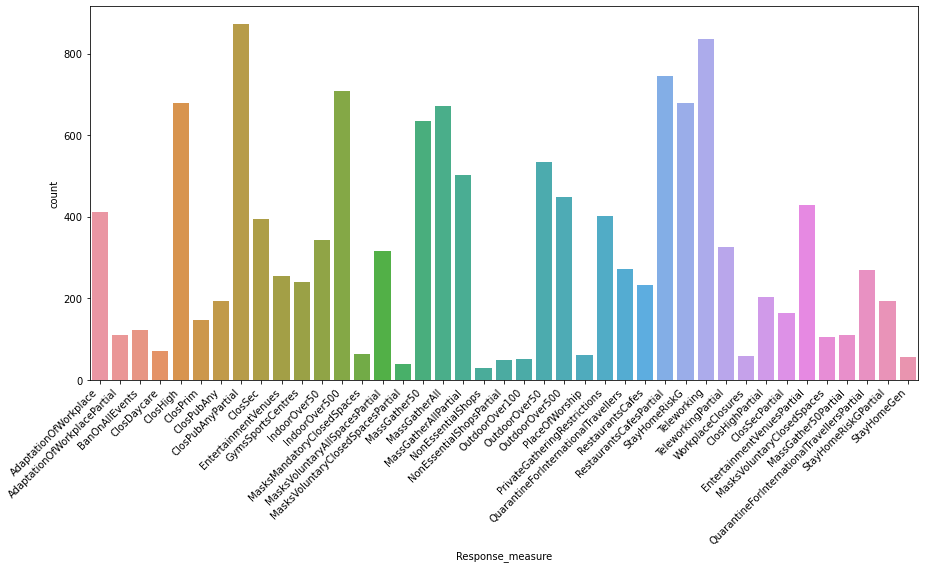

In [11]:
plt.subplots(figsize=(13,8))
p=sns.countplot(x="Response_measure",data=df)
p.set_xticklabels(p.get_xticklabels(), rotation=45,ha="right")
plt.tight_layout()
plt.show()

Now a countplot of the number of restrictions is performed to see how they used restrictions differently. Here it is clear that Denmark and Finland had by far the most restrictions in effect. While Sweden especially used much less restrictions. This fits well with the general picture of the number of restrictions in 2020. That said, the number of restrictions is not a dirrect measure of how extreme the measures was and thereby how much they affect daily life. 

Link: https://en.wikipedia.org/wiki/Swedish_government_response_to_the_COVID-19_pandemic

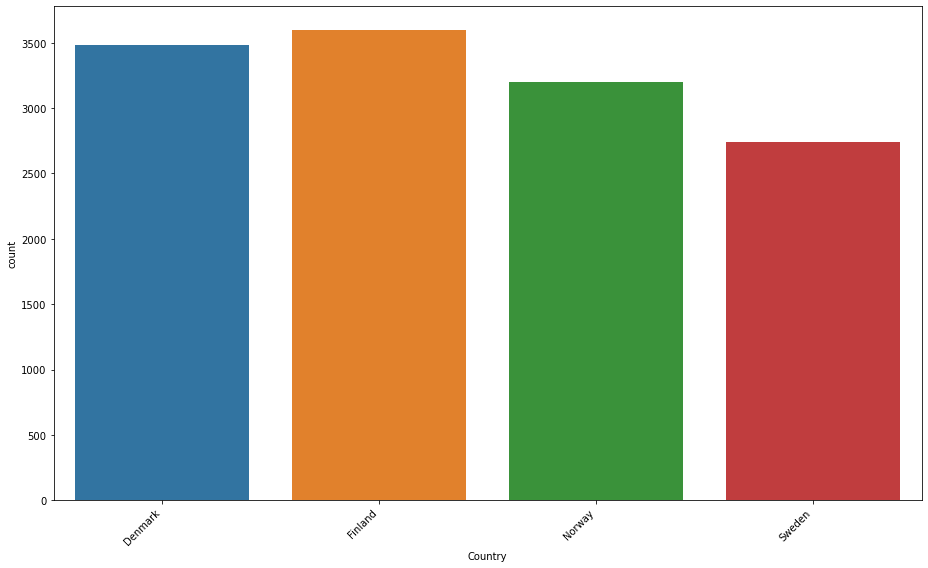

In [12]:
plt.subplots(figsize=(13,8))
p=sns.countplot(x="Country",data=df)
p.set_xticklabels(p.get_xticklabels(), rotation=45,ha="right")
plt.tight_layout()
plt.show()

# HISTOGRAMS FOR NO2 DATA

Loading BokehJS ...

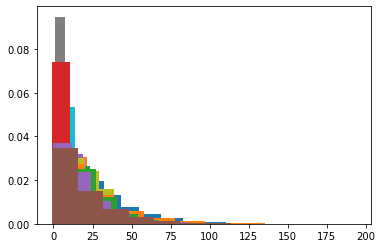

In [13]:
### Make histograms of data
## Create empty plot
p_dk = figure(title="Histogram of NO2 - Denmark",plot_width=750, plot_height=500)
p_dk.xaxis.axis_label = 'NO2 in µg/m3'
p_dk.yaxis.axis_label = 'Frequency of occurences'
dk_data = [dk2019, dk2020, dk2019_2, dk2020_2]
dk_label = ["2019 - København", "2020 - København", "2019 - Århus", "2020 - Århus"]

p_fi = figure(title="Histogram of NO2 - Finland",plot_width=750, plot_height=500)
p_fi.xaxis.axis_label = 'NO2 in µg/m3'
p_fi.yaxis.axis_label = 'Frequency of occurences'
fi_data = [fi2019, fi2020, fi2019_2, fi2020_2]
fi_label = ["2019 - Helsinki", "2020 - Helsinki", "2019 - Oulu", "2020 - Oulu"]


p_no = figure(title="Histogram of NO2 - Norway",plot_width=750, plot_height=500)
p_no.xaxis.axis_label = 'NO2 in µg/m3'
p_no.yaxis.axis_label = 'Occurences'
no_data = [no2019, no2020, no2019_2, no2020_2]
no_label = ["2019 - Oslo", "2020 - Oslo", "2019 - Trondheim", "2020 - Trondheim"]


p_se = figure(title="Histogram of NO2 - Sweden",plot_width=750, plot_height=500)
p_se.xaxis.axis_label = 'NO2 in µg/m3'
p_se.yaxis.axis_label = 'Occurences'
se_data = [se2019, se2020, se2019_2, se2020_2]
se_label = ["2019 - Stockholm", "2020 - Stockholm", "2019 - Umeå", "2020 - Umeå"]

## Add histograms
hist_dk = {}
hist_fi = {}
hist_no = {}
hist_se = {}
colors = ['green','limegreen', "orange", "darkorange"]
year = ["2019", "2020", "2019_2", "2020_2"]
items_dk = [] # for the custom legend
items_fi= []
items_no = []
items_se = []

for indx,i in enumerate(year):
    hist_tmp, edges, q = plt.hist(dk_data[indx]["Concentration"], bins = 10, density = True)
    hist_dk[i] = p_dk.quad(top = hist_tmp, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color=colors[indx], line_color="white", alpha=0.6, muted_alpha = 0.05)
    hist_tmp, edges, q = plt.hist(fi_data[indx]["Concentration"], density = True)
    hist_fi[i] = p_fi.quad(top = hist_tmp, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color=colors[indx], line_color="white", alpha=0.6, muted_alpha = 0.05)
    hist_tmp, edges, q = plt.hist(no_data[indx]["Concentration"], density = True)
    hist_no[i] = p_no.quad(top = hist_tmp, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color=colors[indx], line_color="white", alpha=0.6, muted_alpha = 0.05)
    hist_tmp, edges, q = plt.hist(se_data[indx]["Concentration"], density = True)
    hist_se[i] = p_se.quad(top = hist_tmp, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color=colors[indx], line_color="white", alpha=0.6, muted_alpha = 0.05)
    items_dk.append((dk_label[indx], [hist_dk[i]])) # figure out where to add it
    items_fi.append((fi_label[indx], [hist_fi[i]])) # figure out where to add it
    items_no.append((no_label[indx], [hist_no[i]])) # figure out where to add it
    items_se.append((se_label[indx], [hist_se[i]])) # figure out where to add it



legend_dk = Legend(items=items_dk, location=(0, -30)) # figure out where to add it
legend_fi = Legend(items=items_fi, location=(0, -30)) # figure out where to add it
legend_no = Legend(items=items_no, location=(0, -30)) # figure out where to add it
legend_se = Legend(items=items_se, location=(0, -30)) # figure out where to add it
p_dk.add_layout(legend_dk, 'left') # figure where to add it
p_dk.legend.click_policy="mute" #assigns the click policy (you can try to use ''hide')
p_fi.add_layout(legend_fi, 'left') # figure where to add it
p_fi.legend.click_policy="mute" #assigns the click policy (you can try to use ''hide')
p_no.add_layout(legend_no, 'left') # figure where to add it
p_no.legend.click_policy="mute" #assigns the click policy (you can try to use ''hide')
p_se.add_layout(legend_se, 'left') # figure where to add it
p_se.legend.click_policy="mute" #assigns the click policy (you can try to use ''hide')


## Combine plots using tabs
l1 = layout([[p_dk]])
l2 = layout([[p_fi]])
l3 = layout([[p_no]])
l4 = layout([[p_se]])

tab1 = Panel(child=l1,title="Denmark")
tab2 = Panel(child=l2,title="Finland")
tab3 = Panel(child=l3,title="Norway")
tab4 = Panel(child=l4,title="Sweden")
tabs = Tabs(tabs=[ tab1, tab2, tab3, tab4 ])

curdoc().add_root(tabs)
output_notebook()
show(tabs)

# TIME SERIES FOR NO2 DATA

In [14]:
## Time series data for all countries
legend_names = ["2019 - København", "2019 - Århus", "2020 - København", "2020 - Århus", "2019 - Helsinki", "2019 - Oulu", "2020 - Helsinki", "2020 - Oulu", "2019 - Oslo" , "2019 - Trondheim", "2020 - Oslo", "2020 - Trondheim", "2019 - Stockholm", "2019 - Umeå", "2020 - Stockholm", "2020 - Umeå"]
colors = ["blue", "deepskyblue", "blue" , "deepskyblue", "limegreen", "seagreen", "limegreen" , "seagreen", "orange", "coral", "orange", "coral", "orchid", "magenta", "orchid", "magenta"]

## Daily means
p_day = figure(title="Time series of measurements of NO2",plot_width=750, plot_height=500,x_axis_type= 'datetime')
p_day.xaxis.axis_label = 'Week number'
p_day.yaxis.axis_label = 'NO2 in µg/m3'

line_day = {}
items_day = []

## Weekly means
p_week = figure(title="Time series of measurements of NO2",plot_width=750, plot_height=500)
p_week.xaxis.axis_label = 'Month number'
p_week.yaxis.axis_label = 'NO2 in µg/m3'

line_week = {}
items_week = []

## Monthly means
p_mon = figure(title="Time series of measurements of NO2",plot_width=750, plot_height=500)
p_mon.xaxis.axis_label = 'Time'
p_mon.yaxis.axis_label = 'NO2 in µg/m3'

line_mon = {}
items_mon = []


for idx, dataset in enumerate(weekly_means):
    line_day[legend_names[idx]] = p_day.line(daily_means[idx]["Date"], daily_means[idx]["Concentration"], color = colors[idx], alpha=0.6, muted_alpha = 0.05,muted=True)
    items_day.append((legend_names[idx], [line_day[legend_names[idx]]])) # figure out where to add it

    line_week[legend_names[idx]] = p_week.line(weekly_means[idx]["Week"], weekly_means[idx]["Concentration"], color = colors[idx], alpha=0.6, muted_alpha = 0.05,muted=True)
    items_week.append((legend_names[idx], [line_week[legend_names[idx]]])) # figure out where to add it

    line_mon[legend_names[idx]] = p_mon.line(monthly_means[idx]["Month"], monthly_means[idx]["Concentration"], color = colors[idx], alpha=0.6, muted_alpha = 0.05,muted=True)
    items_mon.append((legend_names[idx], [line_mon[legend_names[idx]]])) # figure out where to add it

legend_day = Legend(items=items_day, location=(0, -30)) # figure out where to add it
legend_week = Legend(items=items_week, location=(0, -30)) # figure out where to add it
legend_mon = Legend(items=items_mon, location=(0, -30)) # figure out where to add it

p_day.add_layout(legend_day, 'left') # figure where to add it
p_day.legend.click_policy="mute" #assigns the click policy (you can try to use ''hide')

p_week.add_layout(legend_week, 'left') # figure where to add it
p_week.legend.click_policy="mute" #assigns the click policy (you can try to use ''hide')

p_mon.add_layout(legend_mon, 'left') # figure where to add it
p_mon.legend.click_policy="mute" #assigns the click policy (you can try to use ''hide')

## Combine plots using tabs
l1 = layout([[p_day]])
l2 = layout([[p_week]])
l3 = layout([[p_mon]])

tab1 = Panel(child=l1,title="Daily means")
tab2 = Panel(child=l2,title="Weekly means")
tab3 = Panel(child=l3,title="Monthly means")
tabs = Tabs(tabs=[ tab1, tab2, tab3])
  
curdoc().add_root(tabs)
output_notebook()
show(tabs)

Loading BokehJS ...

In [15]:
data[0]

,SamplingPoint,Concentration,Date,Week,Month,Year,lon,lat
0,SPO-DK0030A_00008_110,22.827,2019-01-01,1,1,2019,12.553336,55.698334
1,SPO-DK0030A_00008_110,11.696,2019-01-01,1,1,2019,12.553336,55.698334
2,SPO-DK0030A_00008_110,7.189,2019-01-01,1,1,2019,12.553336,55.698334
3,SPO-DK0030A_00008_110,NaN,2019-01-01,1,1,2019,12.553336,55.698334
4,SPO-DK0030A_00008_110,0.230,2019-01-01,1,1,2019,12.553336,55.698334
...,...,...,...,...,...,...,...,...
8755,SPO-DK0030A_00008_110,8.312,2019-12-31,1,12,2019,12.553336,55.698334
8756,SPO-DK0030A_00008_110,17.543,2019-12-31,1,12,2019,12.553336,55.698334
8757,SPO-DK0030A_00008_110,17.470,2019-12-31,1,12,2019,12.553336,55.698334
8758,SPO-DK0030A_00008_110,11.767,2019-12-31,1,12,2019,12.553336,55.698334


# Differences in corona restrictions across Scandinavia

Though Scandinavia is deemed a fairly homogeneous population, both with the regards to the people living there and the way their communites are build, their response to covid-19 varied a fair amount. In the begninning of the pandemic Norway, Finalnd and Denmark used hard restrictions to avoid the virus spreading, while Sweden took a more lax approach. The same seemed to be the case for the second wave of the pandemic, it actually changed towards the end of 2020, where Sweden enforced the most limiting restrictions. 

Looking at the below plot it can be seen that through 2020, Norway had the most days with restrictions, while the difference was very little, which is because all three countries enacted restrictions between the 10th and 12th of March. This makes the period of interest very similair, which is important, as it was seen in the data for NO2 data that seasonal changes already existed in 2019. 







Link: https://www.sciencedirect.com/science/article/pii/S0313592621000643

## PLOT NUMBER OF RESTRICTIONS PER COUNTRY IN TOTAL.

In [16]:
data_rest = pd.get_dummies(df,prefix=['Response_measure'], columns = ['Response_measure']).sort_values(by="DATE_VALUE")

In [17]:
data_rest.groupby("Country").sum()

,Response_measure_AdaptationOfWorkplace,Response_measure_AdaptationOfWorkplacePartial,Response_measure_BanOnAllEvents,Response_measure_ClosDaycare,Response_measure_ClosHigh,Response_measure_ClosHighPartial,Response_measure_ClosPrim,Response_measure_ClosPubAny,Response_measure_ClosPubAnyPartial,Response_measure_ClosSec,...,Response_measure_QuarantineForInternationalTravellers,Response_measure_QuarantineForInternationalTravellersPartial,Response_measure_RestaurantsCafes,Response_measure_RestaurantsCafesPartial,Response_measure_StayHomeGen,Response_measure_StayHomeRiskG,Response_measure_StayHomeRiskGPartial,Response_measure_Teleworking,Response_measure_TeleworkingPartial,Response_measure_WorkplaceClosures
Country,,,,,,,,,,,,,,,,,,,,,
Denmark,234.0,4.0,67.0,31.0,154.0,0.0,42.0,36.0,260.0,80.0,...,13.0,0.0,77.0,212.0,0.0,293.0,0.0,110.0,184.0,59.0
Finland,0.0,0.0,0.0,0.0,139.0,150.0,58.0,75.0,214.0,139.0,...,89.0,200.0,75.0,135.0,0.0,99.0,192.0,137.0,141.0,0.0
Norway,0.0,0.0,56.0,40.0,95.0,53.0,46.0,81.0,214.0,61.0,...,170.0,69.0,81.0,214.0,57.0,82.0,0.0,297.0,0.0,0.0
Sweden,177.0,105.0,0.0,0.0,290.0,0.0,0.0,0.0,184.0,115.0,...,0.0,0.0,0.0,184.0,0.0,205.0,0.0,291.0,0.0,0.0


In [18]:
count=data_rest.groupby(["Country","DATE_VALUE"]).sum()
n_rest=count.sum(axis=1)
n_rest=n_rest.rename("Number of restrictions").reset_index()
test=n_rest.groupby("Country").count().reset_index()

In [19]:
# MAKE STATIONARY GEO PLOT
geo_str = json.dumps(json.load(open("world-countries.json", 'r'))) # map data

In [20]:
mapeu = folium.Map(location=[64, 11], # Munich coordinates
                  zoom_start=4)
folium.GeoJson(
    geo_str,
    name='geojson'
).add_to(mapeu)

folium.Choropleth(
            geo_data=geo_str, # map data
            data=test, # dataframe
            columns=['Country','Number of restrictions'], # used columns
            fill_color='Blues',
            key_on='feature.properties.name',#geojson country code
    legend_name='Total number of restriction days'
                        ).add_to(mapeu)
mapeu

## Barplot over hard restrictions

As mentioned the restrictions vaired quite a lot for the different countries, this can also be seen when accessing the most restrictive across the different countries. Focussing first on restrictions closing the public spaces totally it is clear to see the difference in strategies. While both Finland and Norway had public spaces, such as restaurants and entertainment venues closed completely for around 80 days, Sweden never enacted this restriction. The next restriction is focussing on non essential shops, where they were closed in Denmark for nearly 30 days, it should be noted though that these would also be closed under the closure of public spaces restriction in Finland and Norway. This shows a more flexible adaption in Denmark, opening some parts of its public spaces before Finland and Norway. Again Sweden is never even enacted a closing of non essential shops. 

The third restrictions is with regards to daycare centers, which meant the smallest children all had to stay home. Here only Denmark and Norway enacted the restrictions, again supporting these two countries as having hard restrictions. The same can be seen for the an enacted ban on all events, which ensure no events, neither outside or inside was allowed. Here Denmark and Norway was the only two countries where this was enacted and for both it was in effect for more than 50 days. 

Finally the closure of high schools is interesting, here Sweden is the clear leader with a full closure of high school for most of 2020 (the high schools are also counted as closed through the summer vacation, which can be slightly misinforming). High schools students are in general easier to send home, as it is not considered necessary that an adult is also at home. This shows the difference in approach for the four countries quite clearly. 

In [21]:
# Create list of countries and colors to use
colors = ['red','green', "yellow", "blue"]
countries = ["Denmark", "Finland", "Norway", "Sweden"]
### Make histograms of data
## Create empty plot
p_CP = figure(title="Barplot of days with Closure of public spaces",plot_width=750, plot_height=500,x_range=countries)
p_CP.xaxis.axis_label = 'Country'
p_CP.yaxis.axis_label = 'Days with restriction'
ClosPubAny=data_rest[["Country","Response_measure_ClosPubAny"]].groupby("Country").sum().reset_index()

## Create empty plot
p_NES = figure(title="Barplot of days with non essential shops closed",plot_width=750, plot_height=500,x_range=countries)
p_NES.xaxis.axis_label = 'Country'
p_NES.yaxis.axis_label = 'Days with restriction'
NonEssentialShops=data_rest[["Country","Response_measure_NonEssentialShops"]].groupby("Country").sum().reset_index()

## Create empty plot
p_CD = figure(title="Barplot of days with closed daycare",plot_width=750, plot_height=500,x_range=countries)
p_CD.xaxis.axis_label = 'Country'
p_CD.yaxis.axis_label = 'Days with restriction'
ClosDaycare=data_rest[["Country","Response_measure_ClosDaycare"]].groupby("Country").sum().reset_index()

## Create empty plot
p_BE = figure(title="Barplot of days with ban on all events",plot_width=750, plot_height=500,x_range=countries)
p_BE.xaxis.axis_label = 'Country'
p_BE.yaxis.axis_label = 'Days with restriction'
BanOnAllEvents=data_rest[["Country","Response_measure_BanOnAllEvents"]].groupby("Country").sum().reset_index()


## Create empty plot
p_CH = figure(title="Barplot of days with closed high schools",plot_width=750, plot_height=500,x_range=countries)
p_CH.xaxis.axis_label = 'Country'
p_CH.yaxis.axis_label = 'Days with restriction'
ClosHigh=data_rest[["Country","Response_measure_ClosHigh"]].groupby("Country").sum().reset_index()



## Create bar plot
p_CP.vbar(x=ClosPubAny["Country"], top=ClosPubAny["Response_measure_ClosPubAny"], width=0.9,color=colors)
p_NES.vbar(x=NonEssentialShops["Country"], top=NonEssentialShops["Response_measure_NonEssentialShops"], width=0.9,color=colors)
p_CD.vbar(x=ClosDaycare["Country"], top=ClosDaycare["Response_measure_ClosDaycare"], width=0.9,color=colors)
p_BE.vbar(x=BanOnAllEvents["Country"], top=BanOnAllEvents["Response_measure_BanOnAllEvents"], width=0.9,color=colors)
p_CH.vbar(x=ClosHigh["Country"], top=ClosHigh["Response_measure_ClosHigh"], width=0.9,color=colors)





## Combine plots using tabs
l1 = layout([[p_CP]])
l2 = layout([[p_NES]])
l3 = layout([[p_CD]])
l4 = layout([[p_BE]])
l5 = layout([[p_CH]])

tab1 = Panel(child=l1,title="Closure of public spaces")
tab2 = Panel(child=l2,title="Non essential shops")
tab3 = Panel(child=l3,title="Closed daycare")
tab4 = Panel(child=l4,title="Ban on all events")
tab5 = Panel(child=l5,title="Closed High Schools")
tabs = Tabs(tabs=[ tab1, tab2, tab3, tab4,tab5 ])

curdoc().add_root(tabs)
output_notebook()
show(tabs)

Loading BokehJS ...

## PLOT NUMBER OF RESTRICTIONS AS TOTAL PER DAY FOR EACH COUNTRY

The number of restrictions in effect per day is also a good measure of the policies led by the different countries. It is clear that Denmark, Finland and Norway had close to the same number of restrictions in place through the period and reacted fast in the beggining, while also ending the year with the most restrictions. Sweden on the other hand did not enact as many restrictions at the same time through the whole period. 

In [22]:
# MAKE GEOPLOT WITH TIME 
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries = countries.rename(columns={'name': 'Country'})
joined_df=n_rest.merge(countries, on='Country')

In [23]:
# The next code parts are based on the following link:
#https://www.jumpingrivers.com/blog/interactive-maps-python-covid-19-spread/
#Create color mapping
max_colour = max(joined_df['Number of restrictions'])
min_colour = min(joined_df['Number of restrictions'])
cmap = cm.linear.YlOrRd_09.scale(min_colour, max_colour)
joined_df['colour'] = joined_df['Number of restrictions'].map(cmap)

In [24]:
#List of countries to map
country_list = joined_df['Country'].unique().tolist()
country_idx = range(len(country_list))
# Create style_dict for time slider choropleth
style_dict = {}
# Change date to seconds and right data format for plot
a_timedelta=joined_df.DATE_VALUE-datetime.datetime(1970, 1, 1)
joined_df['DATE_SEC']=a_timedelta.dt.total_seconds().astype('U10')
for i in country_idx:
    country = country_list[i]
    result = joined_df[joined_df['Country'] == country]
    inner_dict = {}
    for _, r in result.iterrows():
        inner_dict[r['DATE_SEC']] = {'color': r['colour'], 'opacity': 5}
    style_dict[str(i)] = inner_dict

In [25]:
countries_df = joined_df[['geometry']]
countries_gdf = gpd.GeoDataFrame(countries_df)
countries_gdf = countries_gdf.drop_duplicates().reset_index()

In [26]:
slider_map = folium.Map(location=[64, 11], zoom_start=4,min_zoom=1, max_bounds=True,tiles='cartodbpositron')
_ = TimeSliderChoropleth(
    data=countries_gdf.to_json(),
    styledict=style_dict,

).add_to(slider_map)
_ = cmap.add_to(slider_map)
cmap.caption = "Number of restrictions"
slider_map.save(outfile='TimeSliderChoropleth.html')
slider_map

# DATA PREP NO2 DATA

In [27]:
# Collect NO2 data to use with geo mapping by first creating country column
data[0]["Country"]="Denmark"
data[1]["Country"]="Denmark"
data[2]["Country"]="Denmark"
data[3]["Country"]="Denmark"
data[4]["Country"]="Finland"
data[5]["Country"]="Finland"
data[6]["Country"]="Finland"
data[7]["Country"]="Finland"
data[8]["Country"]="Norway"
data[9]["Country"]="Norway"
data[10]["Country"]="Norway"
data[11]["Country"]="Norway"
data[12]["Country"]="Sweden"
data[13]["Country"]="Sweden"
data[14]["Country"]="Sweden"
data[15]["Country"]="Sweden"
# Then creating city columns
data[0]["City"]="Copenhagen"
data[1]["City"]="Aarhus"
data[2]["City"]="Copenhagen"
data[3]["City"]="Aarhus"
data[4]["City"]="Helsinki"
data[5]["City"]="Oulu"
data[6]["City"]="Helsinki"
data[7]["City"]="Oulu"
data[8]["City"]="Oslo"
data[9]["City"]="Trondheim"
data[10]["City"]="Oslo"
data[11]["City"]="Trondheim"
data[12]["City"]="Stockholm"
data[13]["City"]="Umeaa"
data[14]["City"]="Stockholm"
data[15]["City"]="Umeaa"
base_frames=[data[0],data[2],data[4],data[6],data[8],data[10],data[12],data[14]]
all_frames=[data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],data[8],data[9],data[10],data[11],data[12],data[13],data[14],data[15]]
base_data=pd.concat(base_frames)
all_data=pd.concat(all_frames)

In [28]:
data[0]

,SamplingPoint,Concentration,Date,Week,Month,Year,lon,lat,Country,City
0,SPO-DK0030A_00008_110,22.827,2019-01-01,1,1,2019,12.553336,55.698334,Denmark,Copenhagen
1,SPO-DK0030A_00008_110,11.696,2019-01-01,1,1,2019,12.553336,55.698334,Denmark,Copenhagen
2,SPO-DK0030A_00008_110,7.189,2019-01-01,1,1,2019,12.553336,55.698334,Denmark,Copenhagen
3,SPO-DK0030A_00008_110,NaN,2019-01-01,1,1,2019,12.553336,55.698334,Denmark,Copenhagen
4,SPO-DK0030A_00008_110,0.230,2019-01-01,1,1,2019,12.553336,55.698334,Denmark,Copenhagen
...,...,...,...,...,...,...,...,...,...,...
8755,SPO-DK0030A_00008_110,8.312,2019-12-31,1,12,2019,12.553336,55.698334,Denmark,Copenhagen
8756,SPO-DK0030A_00008_110,17.543,2019-12-31,1,12,2019,12.553336,55.698334,Denmark,Copenhagen
8757,SPO-DK0030A_00008_110,17.470,2019-12-31,1,12,2019,12.553336,55.698334,Denmark,Copenhagen
8758,SPO-DK0030A_00008_110,11.767,2019-12-31,1,12,2019,12.553336,55.698334,Denmark,Copenhagen


In [29]:
#Make daily dataset for main stations
no2_data=base_data[["Date","Concentration","Country"]].groupby(["Date","Country"]).mean().dropna().reset_index()
no2_data["Date"] =pd.to_datetime(no2_data["Date"])
#Make daily dataset for all stations
all_no2_data=all_data[["Date","Concentration","Country","City",'lon','lat']].groupby(["Date","Country","City"]).mean().dropna().reset_index()
all_no2_data['Date']=pd.to_datetime(all_no2_data['Date'])

## CREATE TIME SLIDER PLOT OVER AVERAGE DAILY NO2 VALUES FOR LARGEST CITY IN COUNTRIES.

Now the changes in no2 levels across the counries are compared over time. Here it becomes clear that especially in 2019 there are quite a lot of observations where the daily average across the stations in the countries are above both the 10 and 25 limit, which are the recommended yearly and daily limits from WHO. Especially the stations in Denmark and Norway seems to be problematic. Ones the covid 19 restrictions kicks in there is a clear difference. In general the air pollution becomes much smaller and instead of much days being at levels clearly above they are now around the limit or below for the average values. 


This indicates that the initial hypothesis, that corona restrictions might influence the concentration of NO2 considerably, might be correct. A deeper analysis into the correlation between NO2 levels and corona restrictions is therefore highly relevant. 

In [30]:
# The next code parts are based on the following link:
#https://www.jumpingrivers.com/blog/interactive-maps-python-covid-19-spread/
#Create color mapping
joined_df2=no2_data.merge(countries, on='Country')
max_colour = max(joined_df2['Concentration'])
min_colour = min(joined_df2['Concentration'])
cmap = cm.StepColormap(["green","yellow","red"],index=[1,7,25,25,35],vmin=min_colour,vmax=max_colour).scale(min_colour,max_colour).to_linear()

joined_df2['colour'] = joined_df2['Concentration'].map(cmap)
joined_df2["Date"] =pd.to_datetime(joined_df2["Date"])

In [31]:
#List of countries to map
country_list = joined_df2['Country'].unique().tolist()
country_idx = range(len(country_list))
# Create style_dict for time slider choropleth
style_dict = {}
# Change date to seconds and right data format for plot
a_timedelta=joined_df2.Date-datetime.datetime(1970, 1, 1)
joined_df2['DATE_SEC']=a_timedelta.dt.total_seconds().astype('U10')
for i in country_idx:
    country = country_list[i]
    result = joined_df2[joined_df2['Country'] == country]
    inner_dict = {}
    for _, r in result.iterrows():
        inner_dict[r['DATE_SEC']] = {'color': r['colour'], 'opacity': 5}
    style_dict[str(i)] = inner_dict

In [32]:
countries_df = joined_df2[['geometry']]
countries_gdf = gpd.GeoDataFrame(countries_df)
countries_gdf = countries_gdf.drop_duplicates().reset_index()

In [33]:
slider_map = folium.Map(location=[64, 11], zoom_start=4,min_zoom=1, max_bounds=True,tiles='cartodbpositron')
_ = TimeSliderChoropleth(
    data=countries_gdf.to_json(),
    styledict=style_dict,

).add_to(slider_map)
_ = cmap.add_to(slider_map)
cmap.caption = "Daily average NO2 concentration"
slider_map.save(outfile='TimeSliderChoropleth.html')
slider_map

## CREATE CORRELATION PLOT TO SHOW INITAL EFFECT OF RESTRICTIONS.

Looking at the correlation it is clear that the number of restrictions seems to have a reducing impact of on the NO2 levels. The impact seems be highest for Norway and Finland, which is not surprising as they had many days with high NO2 levels before restrictions was enacted, while they had nearly non after the restrictions was enacted. 

With this knowledge of a negative correaltion the next step is to start analysing the differences of the different restrictions to see if any of those could be relevant for future reductions in NO2 levels.

In [34]:
# Change date column to be in same dataformat and with same name.
n_rest=n_rest.rename(columns={"DATE_VALUE":"Date"})
no2_data["Date"]=pd.to_datetime(no2_data.Date)

In [35]:
new_df=no2_data.merge(n_rest,on=["Date","Country"],how="left").fillna(0)

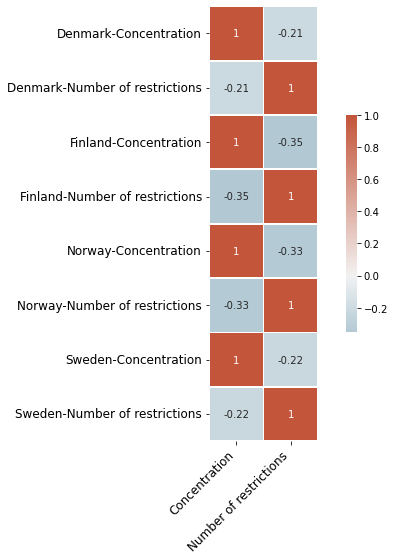

In [36]:
# Generate a mask for the upper triangle
#mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

corr=new_df.groupby("Country").corr()

# Draw the heatmap with the mask and correct aspect ratio
g=sns.heatmap(corr, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.8, cbar_kws={"shrink": 0.5},annot=True,annot_kws={"size":10})
g.set_yticklabels(g.get_yticklabels(), size = 12)
g.set_xticklabels(g.get_xticklabels(), size = 12,ha='right')
g.tick_params(axis='x', labelrotation = 45)
ax.set(xlabel='', ylabel='')


plt.show()

# CREATE WEEKLY PLOT OF NUMBER OF RESTRICTIONS

In [37]:
# Change data to weekly average and look only at 2020
new_df["Year"]=new_df.Date.dt.isocalendar().year
new_df["Week"]=new_df.Date.dt.isocalendar().week

weekly=new_df[["Week","Concentration","Number of restrictions","Country","Year"]].groupby(["Country","Week","Year"]).mean().reset_index()

In [38]:
# Merge date back on and keep only the first date for each week. 
weekly=weekly.merge(new_df[["Week","Country","Date","Year"]], on=["Week","Country","Year"])
weekly=weekly.drop_duplicates(subset=['Week',"Country",'Year'])


In [39]:
# The next code parts are based on the following link:
#https://www.jumpingrivers.com/blog/interactive-maps-python-covid-19-spread/
#Create color mapping
joined_df3=weekly.merge(countries, on='Country')
max_colour = max(joined_df3['Number of restrictions'])
min_colour = min(joined_df3['Number of restrictions'])
cmap = cm.linear.YlOrRd_09.scale(min_colour, max_colour)
joined_df3['colour'] = joined_df3['Number of restrictions'].map(cmap)

In [40]:
#List of countries to map
country_list = joined_df3['Country'].unique().tolist()
country_idx = range(len(country_list))
# Create style_dict for time slider choropleth
style_dict = {}
# Change date to seconds and right data format for plot
a_timedelta=joined_df3.Date-datetime.datetime(1970, 1, 1)
joined_df3['DATE_SEC']=a_timedelta.dt.total_seconds().astype('U10')
for i in country_idx:
    country = country_list[i]
    result = joined_df3[joined_df3['Country'] == country]
    inner_dict = {}
    for _, r in result.iterrows():
        inner_dict[r['DATE_SEC']] = {'color': r['colour'], 'opacity': 5}
    style_dict[str(i)] = inner_dict

In [41]:
countries_df = joined_df3[['geometry']]
countries_gdf = gpd.GeoDataFrame(countries_df)
countries_gdf = countries_gdf.drop_duplicates().reset_index()

In [42]:
slider_map = folium.Map(location=[64, 11], zoom_start=4,min_zoom=1, max_bounds=True,tiles='cartodbpositron')
_ = TimeSliderChoropleth(
    data=countries_gdf.to_json(),
    styledict=style_dict,

).add_to(slider_map)
_ = cmap.add_to(slider_map)
cmap.caption = "Number of restrictions"
slider_map.save(outfile='TimeSliderChoropleth.html')
slider_map

#  CREATE HEATMAP WITH TIME TO SEE WHEN THE CRITICAL LEVEL IS REACHED IN THE DIFFERENT CITIES

In [43]:
# Change data to weekly average and look only at 2020
all_no2_data["Year"]=all_no2_data.Date.dt.isocalendar().year
all_no2_data["Week"]=all_no2_data.Date.dt.isocalendar().week
all_weekly=all_no2_data[["Week","Concentration","City","Country","Year"]].groupby(["Country","Week","Year","City"]).mean().reset_index()

In [44]:
all_weekly=all_weekly.merge(all_no2_data[['City',"Year",'Week','lon','lat',"Date"]],on=['City','Year','Week'],how="left").drop_duplicates(["Week","Country","City"])

In [45]:
df3=all_weekly
# Ensure you're handing it floats
df3['Y'] = df3['lat'].astype(float)
df3['X'] = df3['lon'].astype(float)

df3['Weight'] = df3['Concentration']
df3['Weight'] = df3['Weight'].astype(float)
df3=df3[df3['Weight']>10]
df3 = df3.dropna(axis=0, subset=['Y','X', 'Weight'])

df3_2019=df3[df3['Year']==2019]
df3_2020=df3[df3['Year']==2019]
# List comprehension to make out list of lists
df3_2019 = [[[row['Y'],row['X']] for index, row in df3_2019[df3_2019['Week'] == i].iterrows()] for i in range(0,52)]
df3_2020 = [[[row['Y'],row['X']] for index, row in df3_2020[df3_2020['Week'] == i].iterrows()] for i in range(0,53)]
df3=df3_2019+df3_2020

In [46]:
# Inspiration links:
#https://geohackweek.github.io/ghw2018_web_portal_inlandwater_co2/InteractiveTimeSeries.html 
#https://vverde.github.io/blob/interactivechoropleth.html
slider_map = folium.Map(location=[64, 11], zoom_start=4,min_zoom=1, max_bounds=True,tiles='cartodbpositron')
# Plot it on the map
hm = plugins.HeatMapWithTime(df3,auto_play=True,radius=35,min_opacity=0.1,)
hm.add_to(slider_map)
# Add hover functionality.



# We add a layer controller. 
folium.LayerControl(collapsed=True).add_to(slider_map)
slider_map


# DIFFERENCE BETWEEN 2019 AND 2020 FOR EACH CITY

In [47]:
all_no2_data[['City','Country','Year','Concentration']].groupby(['Country','City','Year']).mean()

Concentration
Country City       Year               
Denmark Aarhus     2019      22.910179
                   2020      20.086604
        Copenhagen 2019      23.677156
                   2020      19.334310
Finland Helsinki   2019      14.967099
                   2020      10.131187
        Oulu       2019      10.314655
                   2020       6.702084
Norway  Oslo       2019      20.545468
                   2020      15.656920
        Trondheim  2019      28.705938
                   2020      18.674485
Sweden  Stockholm  2019      10.396484
                   2020       7.968117
        Umeaa      2019      25.841543
                   2020      19.674272

## PLOT DIFFERENCES IN NO2 LEVEL MADE BY EACH RESTRICTION.

Finally the difference between the pre-covid levels and the NO2 levels when a policy was enacted is compared for the four countries. From this it seems that some restrictions gave quite large reductions in NO2 levels, it should be noted though that there is some interdependencies between them, plus some restrictions was mainly active in the winter period, where reductions was largest, while other was active during the summer months, where reductions was minimal.

Looking at the biggest reductions in NO2 levels it seems to be especially closures of public spaces, either completely or paritally, plus restrictions on the number of persons that are allowed to gather. This makes perfect sense as these restrictions are assumed to be very limiting for our need of transportation. 

In [48]:
REST_NO2=all_no2_data[['City','Country','Year','Concentration','Date']].merge(df,left_on=['Country','Date'],right_on=['Country','DATE_VALUE'],how="left").drop(columns=['DATE_VALUE'])

In [49]:
REST_NO2.fillna('Pre-Covid',inplace=True)

In [50]:
REST_NO2

,City,Country,Year,Concentration,Date,Response_measure
0,Aarhus,Denmark,2019,2.668565,2019-01-01,Pre-Covid
1,Copenhagen,Denmark,2019,3.828000,2019-01-01,Pre-Covid
2,Helsinki,Finland,2019,9.126278,2019-01-01,Pre-Covid
3,Oulu,Finland,2019,4.583333,2019-01-01,Pre-Covid
4,Oslo,Norway,2019,8.985925,2019-01-01,Pre-Covid
...,...,...,...,...,...,...
28579,Umeaa,Sweden,2020,22.233333,2020-12-31,MassGatherAll
28580,Umeaa,Sweden,2020,22.233333,2020-12-31,OutdoorOver50
28581,Umeaa,Sweden,2020,22.233333,2020-12-31,PrivateGatheringRestrictions
28582,Umeaa,Sweden,2020,22.233333,2020-12-31,RestaurantsCafesPartial


In [51]:
effect_rest=REST_NO2[['Response_measure','Concentration','Country']].groupby(['Response_measure','Country']).mean().reset_index()

In [52]:
diff_rest=effect_rest
diff_rest.loc[diff_rest['Country']=='Denmark','Concentration']=diff_rest[diff_rest['Country']=='Denmark'].Concentration-diff_rest[(diff_rest['Response_measure']=='Pre-Covid') & (diff_rest['Country']=='Denmark')].Concentration.to_numpy()
diff_rest.loc[diff_rest['Country']=='Finland','Concentration']=diff_rest[diff_rest['Country']=='Finland'].Concentration-diff_rest[(diff_rest['Response_measure']=='Pre-Covid') & (diff_rest['Country']=='Finland')].Concentration.to_numpy()
diff_rest.loc[diff_rest['Country']=='Norway','Concentration']=diff_rest[diff_rest['Country']=='Norway'].Concentration-diff_rest[(diff_rest['Response_measure']=='Pre-Covid') & (diff_rest['Country']=='Norway')].Concentration.to_numpy()
diff_rest.loc[diff_rest['Country']=='Sweden','Concentration']=diff_rest[diff_rest['Country']=='Sweden'].Concentration-diff_rest[(diff_rest['Response_measure']=='Pre-Covid') & (diff_rest['Country']=='Sweden')].Concentration.to_numpy()

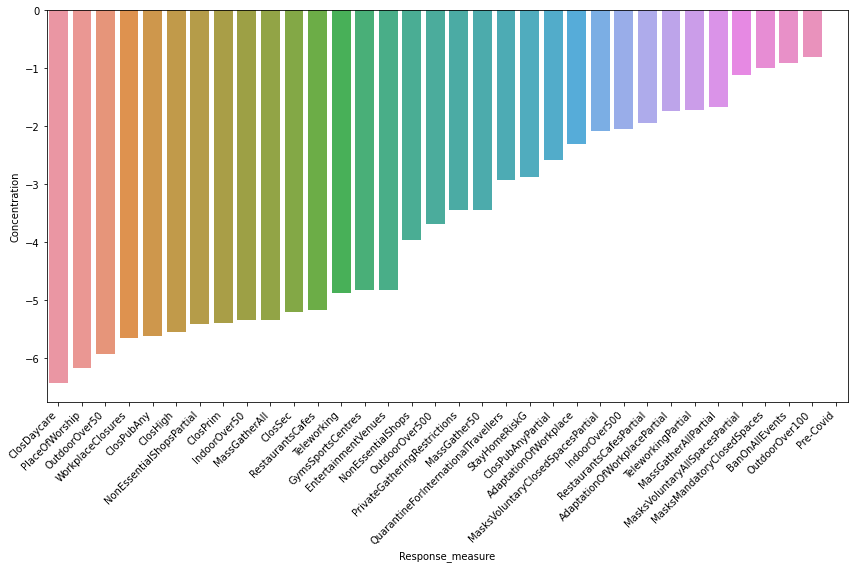

In [53]:
plt.figure(figsize=(12,8))
p=sns.barplot(x='Response_measure',y='Concentration',data=diff_rest[diff_rest['Country']=='Denmark'],order=diff_rest[diff_rest['Country']=='Denmark'].sort_values('Concentration').Response_measure)
p.set_xticklabels(p.get_xticklabels(), rotation=45,ha="right")
plt.tight_layout()
plt.show()

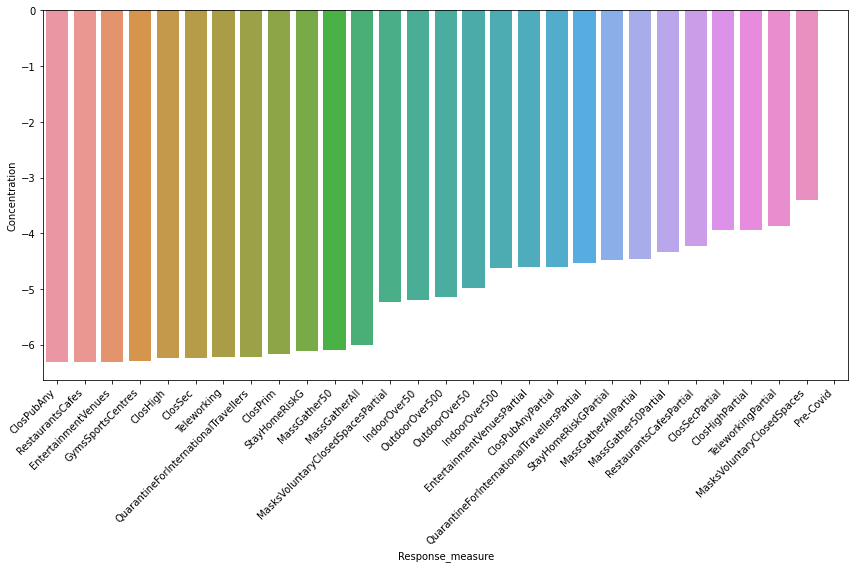

In [54]:
plt.figure(figsize=(12,8))
p=sns.barplot(x='Response_measure',y='Concentration',data=diff_rest[diff_rest['Country']=='Finland'],order=diff_rest[diff_rest['Country']=='Finland'].sort_values('Concentration').Response_measure)
p.set_xticklabels(p.get_xticklabels(), rotation=45,ha="right")
plt.tight_layout()
plt.show()

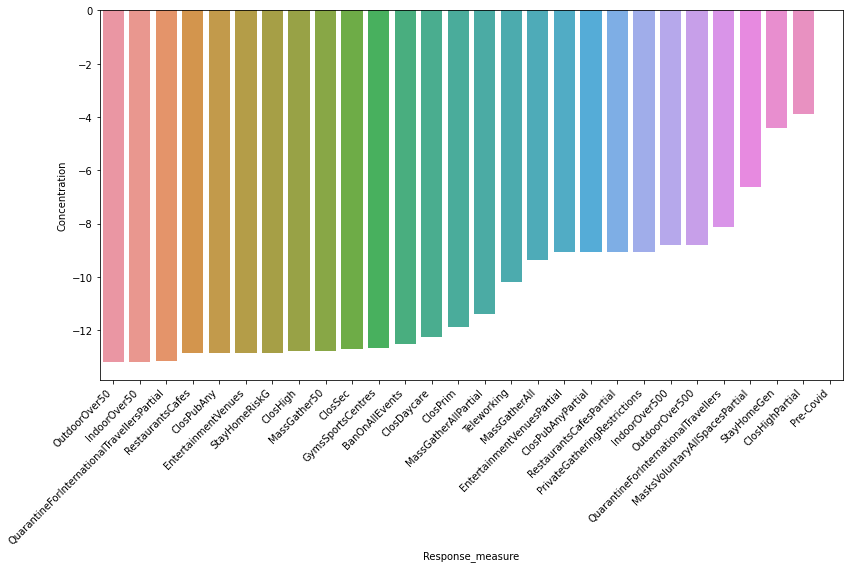

In [55]:
plt.figure(figsize=(12,8))
p=sns.barplot(x='Response_measure',y='Concentration',data=diff_rest[diff_rest['Country']=='Norway'],order=diff_rest[diff_rest['Country']=='Norway'].sort_values('Concentration').Response_measure)
p.set_xticklabels(p.get_xticklabels(), rotation=45,ha="right")
plt.tight_layout()
plt.show()

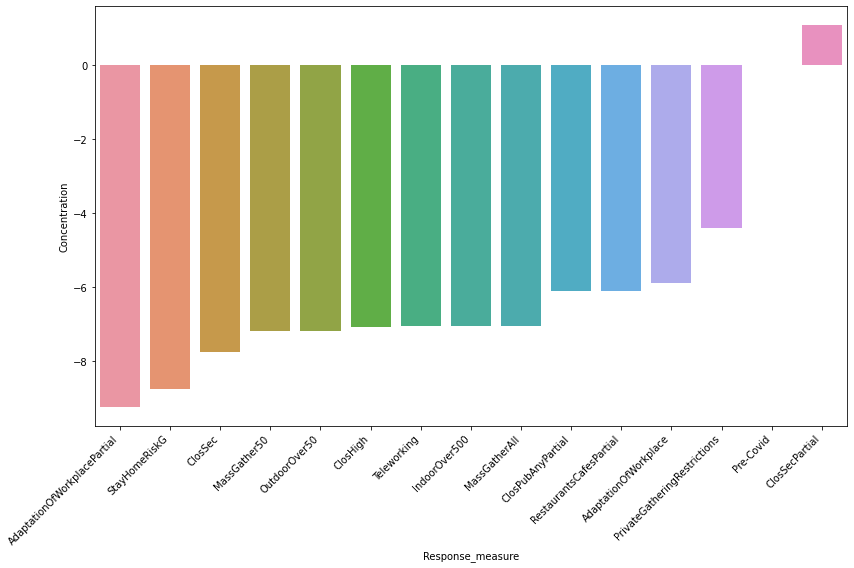

In [56]:
plt.figure(figsize=(12,8))
p=sns.barplot(x='Response_measure',y='Concentration',data=diff_rest[diff_rest['Country']=='Sweden'],order=diff_rest[diff_rest['Country']=='Sweden'].sort_values('Concentration').Response_measure)
p.set_xticklabels(p.get_xticklabels(), rotation=45,ha="right")
plt.tight_layout()
plt.show()

# TODO: 
### ANALYSE AF FORSKEL PER DAG/UGE I LØBET AF ÅRET (ER BESPARELSERNE STØRST OM VINTEREN FX).

